In [ ]:
## comment out if running in colab

import os
os.chdir('../')

# ## if useing Google colab, uncomment the following code

# !git clone https://github.com/nicktfranklin/SEM.git
# import os
# os.chdir('./SEM/')

# !pip install tensorflow==1.9
# !pip install keras==2.2

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from models import *
from sklearn import metrics
from scipy.stats import ttest_ind
import keras as K

import pandas as pd

Using TensorFlow backend.


TensorFlow Version: 1.9.0
Keras      Version: 2.2.0


In [2]:
# SEM parameters
df0 = 1
scale0 = 1.0

lmda = 10**5.
alfa = 10**-2

mode = df0 * scale0 / (df0 + 2)
print("Prior variance (mode): {}".format(mode))

f_class=GRUEvent
# f_class = KerasMultiLayerPerceptron
f_opts=dict(var_scale0=scale0, var_df0=df0, n_epochs = 1, t=5, prior_log_prob=-10.5)

Prior variance (mode): 0.333333333333


In [3]:
from scipy.special import logsumexp
def logsumexp_mean(x):
    return logsumexp(x) - np.log(len(x))

def batch_experiment(n_train = 1400, n_test=600):

    # define the graph structure for the experiment

    g = np.array([
        [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
    ], dtype=float)

    # define the random vectors
    d = 25
    items = np.random.randn(15, d) / np.sqrt(d)


    # draw random walks on the graph
    def sample_pmf(pmf):
        return np.sum(np.cumsum(pmf) < np.random.uniform(0, 1))

    train_nodes = [np.random.randint(15)]
    for _ in range(n_train-1):
        train_nodes.append(sample_pmf(g[train_nodes[-1]] / g[train_nodes[-1]].sum()))
        
    # draw hamiltonian paths from the graph

    # this graph defines the same thing but a preference order as well
    # higher number are  c
    preferred_nodes = np.array([
        [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0],
    ], dtype=float)

    def sample_hamilton(node0):
        is_visited = np.zeros(15, dtype=bool)
        counter = 0
        nodes = []
        while counter < (len(is_visited)):
            p = g[node0] * ~is_visited * preferred_nodes
            if np.sum(p) == 0:
                p = g[node0] * ~is_visited

            node0 = sample_pmf(p / np.sum(p))
            nodes.append(node0)
            is_visited[node0] = True
            counter += 1
        return nodes

    test_nodes = []
    node0 = np.random.randint(15)
    for ii in range(n_test / 15):
        test_nodes += sample_hamilton(node0)
        node0 = test_nodes[-1]

        
    # embed the vectors
    all_nodes = train_nodes + test_nodes
    x = []
    for node in all_nodes:
        x.append(items[node])
    x = np.array(x)
    
    sem_kwargs = dict(lmda=lmda, alfa=alfa, f_class=f_class, f_opts=f_opts)
    sem_model = SEM(**sem_kwargs)
    sem_model.run(x, progress_bar=True)

    
    # prepared diagnostic measures
    clusters = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2]
    node_cluster = []
    for node in test_nodes:
        node_cluster.append(clusters[node])
    node_cluster = np.array(node_cluster)
    
    all_node_cluster = []
    for node in all_nodes:
        all_node_cluster.append(clusters[node])
    all_node_cluster = np.array(all_node_cluster)
    all_boundaries_true = np.concatenate([[False], (all_node_cluster[1:] != all_node_cluster[:-1])])
    
    test_boundaries = sem_model.results.e_hat[n_train-1:-1] != sem_model.results.e_hat[n_train:]
    boundaries = sem_model.results.e_hat[:n_train-1] != sem_model.results.e_hat[1:n_train]
    
    test_bound_prob = sem_model.results.log_boundary_probability[n_train:]
    bound_prob = sem_model.results.log_boundary_probability[1:n_train]
    
    # pull the prediction error (Bayesian Suprise)
    
    test_pe = sem_model.results.surprise[n_train:]
    bound_pe = sem_model.results.surprise[1:n_train]
    
    # cache the correlation between log boundary probability and log surprise
    r = np.corrcoef(
        sem_model.results.log_boundary_probability, sem_model.results.surprise
    )[0][1]

    
    output =  {
#         'Community Transitions (Hamilton)': np.mean(test_boundaries[all_boundaries_true[n_train:]]),
#         'Other Parse (Hamilton)': np.mean(test_boundaries[all_boundaries_true[n_train:]==False]),
        'Community Transitions (Hamilton)': np.exp(logsumexp_mean(test_bound_prob[all_boundaries_true[1400:]])),
        'Other Parse (Hamilton)': np.exp(logsumexp_mean(test_bound_prob[all_boundaries_true[1400:]==False])),
        'Community Transitions (All Other Trials)': np.exp(logsumexp_mean(bound_prob[all_boundaries_true[1:n_train]])),
        'Other Parse (All Other Trials)': np.exp(logsumexp_mean(bound_prob[all_boundaries_true[1:n_train]==False])),
        'PE Community Transitions (Hamilton)': logsumexp_mean(test_pe[all_boundaries_true[1400:]]),
        'PE Other Parse (Hamilton)': logsumexp_mean(test_pe[all_boundaries_true[1400:]==False]),
        'PE Community Transitions (All Other Trials)': logsumexp_mean(bound_pe[all_boundaries_true[1:n_train]]),
        'PE Other Parse (All Other Trials)': logsumexp_mean(bound_pe[all_boundaries_true[1:n_train]==False]),
        'r':r
    }
    
    sem_model.clear_event_models()    
    del sem_model, test_pe, bound_pe, test_boundaries, boundaries, all_boundaries_true, x

    return output
# res = pd.DataFrame(batch_experiment())

In [4]:
from tqdm import tnrange
n_batch = 250
res = []
for ii in tnrange(n_batch):
    res.append(batch_experiment())
res = pd.DataFrame(res)

Run SEM: 100%|██████████| 2000/2000 [00:29<00:00, 67.87it/s]


In [5]:
res.mean()

Community Transitions (All Other Trials)        0.217656
Community Transitions (Hamilton)                0.228951
Other Parse (All Other Trials)                  0.190051
Other Parse (Hamilton)                          0.206153
PE Community Transitions (All Other Trials)    17.922180
PE Community Transitions (Hamilton)            19.638469
PE Other Parse (All Other Trials)              20.076024
PE Other Parse (Hamilton)                      20.050943
r                                              -0.444939
dtype: float64

In [6]:
res.std() / np.sqrt(25)

Community Transitions (All Other Trials)       0.026834
Community Transitions (Hamilton)               0.030575
Other Parse (All Other Trials)                 0.009477
Other Parse (Hamilton)                         0.011814
PE Community Transitions (All Other Trials)    0.633131
PE Community Transitions (Hamilton)            0.637052
PE Other Parse (All Other Trials)              0.351863
PE Other Parse (Hamilton)                      0.426407
r                                              0.026791
dtype: float64

/anaconda3/envs/sem/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


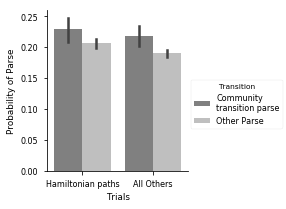

In [7]:
sns.set_context('paper')
columns = ['Community Transitions (Hamilton)','Other Parse (Hamilton)',
           'Community Transitions (All Other Trials)','Other Parse (All Other Trials)']
                                                  
results = pd.melt(res[columns], var_name='group', value_name='Probability of Parse')
all_trials = [s.find('All Other Trials') > -1 for s in results.group.values]
community_tranistion = [s.find('Community') > -1 for s in results.group.values]
results['Transition'] = ['Other Parse'] * len(results)
results.loc[community_tranistion, 'Transition'] = 'Community\ntransition parse'

results['Trials'] = ['Hamiltonian paths'] * len(results)
results.loc[all_trials, 'Trials'] = 'All Others'
sns.factorplot(data=results, y='Probability of Parse', x='Trials', hue='Transition', kind='bar', 
               palette=[[0.5, 0.5, 0.5], [0.75, 0.75, 0.75]], size=3)

plt.savefig('Shapiro250.png', dpi=300, bbox_inches='tight')

In [8]:
from scipy.stats import ttest_ind
ttest_ind(res['Community Transitions (Hamilton)'], res['Other Parse (Hamilton)'], equal_var=False)

Ttest_indResult(statistic=2.199493901916341, pvalue=0.0285538174847983)

In [9]:
ttest_ind(res['Community Transitions (All Other Trials)'], res['Other Parse (All Other Trials)'], equal_var=False)

Ttest_indResult(statistic=3.067452695556412, pvalue=0.0023492087271380774)

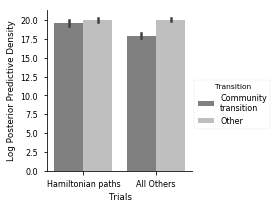

In [62]:
sns.set_context('paper')
columns = ['PE Community Transitions (Hamilton)',
           'PE Other Parse (Hamilton)',
           'PE Community Transitions (All Other Trials)',
           'PE Other Parse (All Other Trials)']
                                                  
results = pd.melt(res[columns], var_name='group', value_name='Probability of Parse')
all_trials = [s.find('All Other Trials') > -1 for s in results.group.values]
community_tranistion = [s.find('Community') > -1 for s in results.group.values]
results['Transition'] = ['Other'] * len(results)
results.loc[community_tranistion, 'Transition'] = 'Community\ntransition'

def exp_logsumexp_mean(x):
    return np.exp(logsumexp_mean(x))


results['Trials'] = ['Hamiltonian paths'] * len(results)
results.loc[all_trials, 'Trials'] = 'All Others'
sns.factorplot(data=results, y='Probability of Parse', x='Trials', hue='Transition', kind='bar', 
               palette=[[0.5, 0.5, 0.5], [0.75, 0.75, 0.75]], size=3, estimator=np.mean)
plt.ylabel('Log Posterior Predictive Density')
plt.savefig('Shapiro_pe.png', dpi=300, bbox_inches='tight')

In [63]:
ttest_ind(res['PE Community Transitions (Hamilton)'],
          res['PE Other Parse (Hamilton)'], equal_var=False)

Ttest_indResult(statistic=-1.7015086633108654, pvalue=0.0895623753593561)

In [64]:
from scipy.stats import ranksums
ranksums(res['PE Community Transitions (Hamilton)'],
          res['PE Other Parse (Hamilton)'])

RanksumsResult(statistic=-1.2913562104529677, pvalue=0.19658018754647977)

In [65]:
ttest_ind(res['PE Community Transitions (All Other Trials)'],
          res['PE Other Parse (All Other Trials)'], equal_var=False)

Ttest_indResult(statistic=-9.4031650872153, pvalue=4.628118465310014e-19)

In [66]:
ranksums(res['PE Community Transitions (All Other Trials)'],
          res['PE Other Parse (All Other Trials)'])

RanksumsResult(statistic=-8.620390810430285, pvalue=6.672598421574155e-18)

/anaconda3/envs/sem/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


-0.4449393968927544
Ttest_1sampResult(statistic=-52.51855575330427, pvalue=1.0414795819628994e-136)


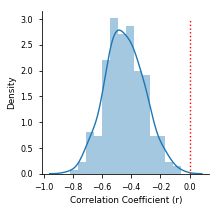

In [55]:
from scipy.stats import ttest_1samp

plt.figure(figsize=(3, 3))
sns.distplot(res['r'],  norm_hist=True, vertical=False)
print np.mean(res['r'])
print ttest_1samp(res['r'], 0)
plt.plot([0, 0], [0, 3], c='r', ls=':')
sns.despine()
plt.xlabel('Correlation Coefficient (r)')
plt.ylabel('Density')

plt.savefig('Schapiro_r.png', dpi=300, bbox_inches='tight')

In [44]:
help(sns.distplot)

Help on function distplot in module seaborn.distributions:

distplot(a, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None)
    Flexibly plot a univariate distribution of observations.
    
    This function combines the matplotlib ``hist`` function (with automatic
    calculation of a good default bin size) with the seaborn :func:`kdeplot`
    and :func:`rugplot` functions. It can also fit ``scipy.stats``
    distributions and plot the estimated PDF over the data.
    
    Parameters
    ----------
    
    a : Series, 1d-array, or list.
        Observed data. If this is a Series object with a ``name`` attribute,
        the name will be used to label the data axis.
    bins : argument for matplotlib hist(), or None, optional
        Specification of hist bins, or None to use Freedman-Diaconis rule.
    hist : bool, optional
        Whether to plot 

In [ ]:
sns.set_context('paper')
columns = ['Community Transitions (Hamilton)','Other Parse (Hamilton)',
           'Community Transitions (All Other Trials)','Other Parse (All Other Trials)']
                                                  
results = pd.melt(res[columns], var_name='group', value_name='Probability of Parse')
all_trials = [s.find('All Other Trials') > -1 for s in results.group.values]
community_tranistion = [s.find('Community') > -1 for s in results.group.values]
results['Transition'] = ['Other Parse'] * len(results)
results.loc[community_tranistion, 'Transition'] = 'Community\ntransition parse'

results['Trials'] = ['Hamiltonian paths'] * len(results)
results.loc[all_trials, 'Trials'] = 'All Others'
sns.factorplot(data=results, y='Probability of Parse', x='Trials', hue='Transition', kind='bar', 
               palette=[[0.5, 0.5, 0.5], [0.75, 0.75, 0.75]], size=3)

# plt.savefig('Shapiro250.png', dpi=300, bbox_inches='tight')

In [26]:
res['PE Community Transitions (All Other Trials)'].mean()

17.922179600072326

In [25]:
 res['PE Other Parse (All Other Trials)'].mean()

20.076023506877892

In [27]:
res['PE Community Transitions (Hamilton)'].mean()

19.638468525150156

In [28]:
 res['PE Other Parse (Hamilton)'].mean()

20.05094260153944